# 3D Computer Vision - Exercise 5
Olivier Kanamugire

On February 08, 2025. 

## Task 1. Line fitting with gradient method (2 points)

In [16]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy.io
import random


Shape of 'xy': (512, 2)
Converged at iteration 534


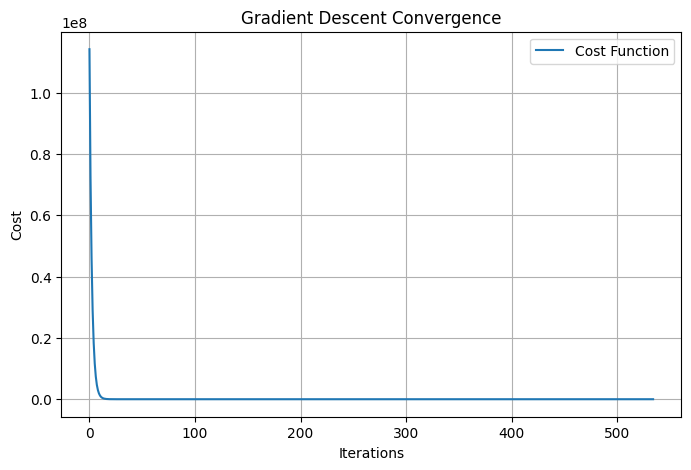

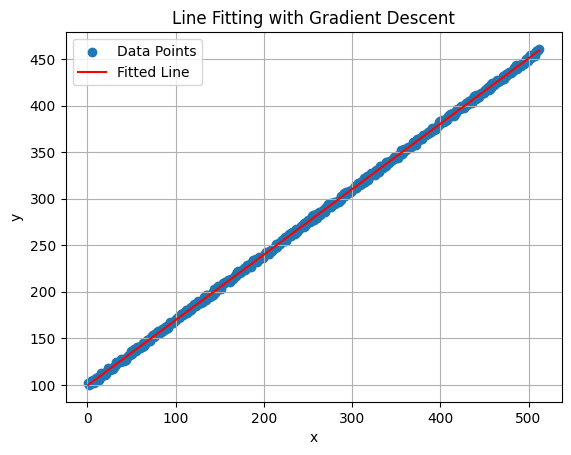

Final parameters: a = 0.007070, b = -0.010052, c = 0.996856


In [2]:
# Load the data
with h5py.File('xy.mat', 'r') as mat:
    xy = mat['xy'][:]
    print("Shape of 'xy':", xy.shape)

x = xy[:, 0]  
y = xy[:, 1]  

# Define functions computing partial derivatives
def daf(x, y, a, b, c):
    return 2 * np.sum((a * x + b * y + c) * x)

def dbf(x, y, a, b, c):
    return 2 * np.sum((a * x + b * y + c) * y)

def dcf(x, y, a, b, c):
    return 2 * np.sum(a * x + b * y + c)

# Cost function (sum of squared errors)
def cost_function(x, y, a, b, c):
    return np.sum((a * x + b * y + c) ** 2)

# Gradient descent parameters
eta = 1e-8 # Step size
iterations = 1000  # Number of iterations
tolerance = 1e-6  # Early stopping threshold

# Initial parameters
a, b, c = 1.0, 1.0, 1.0  

# Store cost values for convergence tracking
cost_values = []

# Gradient descent loop
for i in range(iterations):
    # Compute gradient updates
    da = daf(x, y, a, b, c)
    db = dbf(x, y, a, b, c)
    dc = dcf(x, y, a, b, c)
    
    # Update parameters
    a -= eta * da
    b -= eta * db
    c -= eta * dc

    # Compute cost function
    cost = cost_function(x, y, a, b, c)
    cost_values.append(cost)

    # Print progress every 500 iterations
    #if i % 10 == 0:
    #    print(f"Iteration {i}: Cost = {cost:.5f}")

    # Early stopping if cost change is very small
    if i > 1 and abs(cost_values[-1] - cost_values[-2]) < tolerance:
        print(f'Converged at iteration {i}')
        break

# Plot cost function to show convergence
plt.figure(figsize=(8, 5))
plt.plot(cost_values, label='Cost Function')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Gradient Descent Convergence')
plt.legend()
plt.grid()
plt.show()

# Plot results
plt.scatter(x, y, label='Data Points')
xx = np.linspace(min(x), max(x), 100)
yy = (-a * xx - c) / b  # Rearranging ax + by + c = 0 to get y
plt.plot(xx, yy, 'r-', label='Fitted Line')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Line Fitting with Gradient Descent')
plt.grid()
plt.show()

# Print final parameters
print(f"Final parameters: a = {a:.6f}, b = {b:.6f}, c = {c:.6f}")


# Ablation study

In [3]:
# Different eta values to test
eta_values = [1e-6, 1e-7, 1e-8, 1e-9, 1e-10]
iterations_required = {}

tolerance = 1e-6  
max_iterations = 5000 

for eta in eta_values:
    a, b, c = 1.0, 1.0, 1.0  # Initial parameters
    cost_values = []
    
    for i in range(max_iterations):
        # Compute gradient updates
        da = daf(x, y, a, b, c)
        db = dbf(x, y, a, b, c)
        dc = dcf(x, y, a, b, c)
        
        # Update parameters
        a -= eta * da
        b -= eta * db
        c -= eta * dc

        # Compute cost function
        cost = cost_function(x, y, a, b, c)
        cost_values.append(cost)

        # Early stopping condition
        if i > 1 and abs(cost_values[-1] - cost_values[-2]) < tolerance:
            iterations_required[eta] = i
            break
    else:
        iterations_required[eta] = max_iterations  # If max iterations reached

    print(f"eta: {eta}, iterations: {iterations_required[eta]}, a: {a:.6f}, b: {b:.6f}, c: {c:.6f}")


c:\Users\olivi\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\olivi\AppData\Local\Temp\ipykernel_4492\2431447557.py:21: RuntimeWarning: overflow encountered in square
  return np.sum((a * x + b * y + c) ** 2)
C:\Users\olivi\AppData\Local\Temp\ipykernel_4492\3209678193.py:28: RuntimeWarning: invalid value encountered in scalar subtract
  if i > 1 and abs(cost_values[-1] - cost_values[-2]) < tolerance:
C:\Users\olivi\AppData\Local\Temp\ipykernel_4492\3209678193.py:19: RuntimeWarning: invalid value encountered in scalar subtract
  a -= eta * da
C:\Users\olivi\AppData\Local\Temp\ipykernel_4492\3209678193.py:20: RuntimeWarning: invalid value encountered in scalar subtract
  b -= eta * db


eta: 1e-06, iterations: 5000, a: nan, b: nan, c: nan
eta: 1e-07, iterations: 5000, a: nan, b: nan, c: nan
eta: 1e-08, iterations: 534, a: 0.007070, b: -0.010052, c: 0.996856
eta: 1e-09, iterations: 4454, a: 0.007058, b: -0.010040, c: 0.996857
eta: 1e-10, iterations: 5000, a: 0.004538, b: -0.007539, c: 0.996901


### COMMENT

* The values 1e-6 and 1e-7 are too large, leading to divergence. 
* 1e-8 is ideal value and it gives the same results on only 543 iterations.
* 1e-9 and 1e-10 required extremely many iterations.

## Task 2. RANSAC (2 points)

In [4]:
# Load the data
with h5py.File('circle_points.mat', 'r') as mat:
    points = np.array(mat['points'])  # Adjust the key if necessary

x = points[:,0]
y = points[:,1]

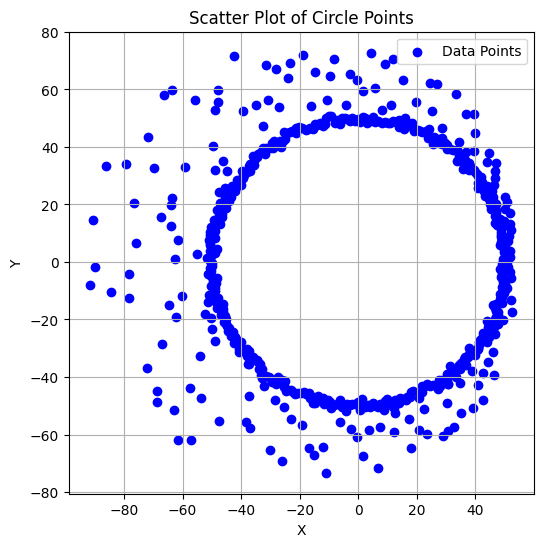

In [5]:
plt.figure(figsize=(6, 6))
plt.scatter(x, y, color='blue', label='Data Points')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Scatter Plot of Circle Points')
plt.legend()
plt.grid()
plt.show()

#### Clearly there are alot of outliers, so lets remove them

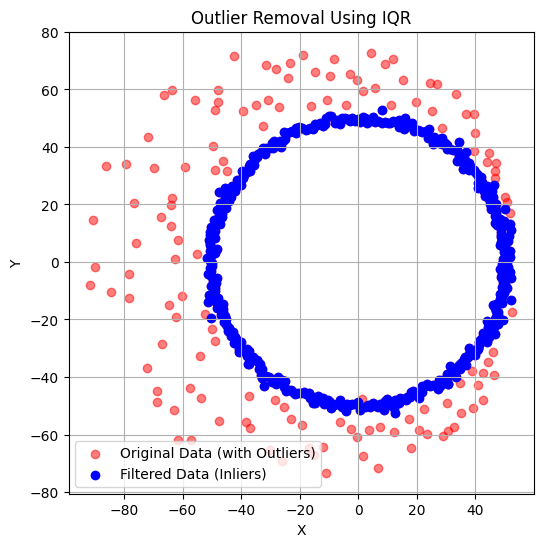

In [6]:
# Compute distances from origin (or estimated center)
distances = np.sqrt(x**2 + y**2)

# Compute IQR to detect outliers
Q1 = np.percentile(distances, 25)
Q3 = np.percentile(distances, 75)
IQR = Q3 - Q1

# Define outlier boundaries
lower_bound = Q1 - 0.5 * IQR
upper_bound = Q3 + 0.1 * IQR

# Mask out inliers
inlier_mask = (distances >= lower_bound) & (distances <= upper_bound)

# Filter outliers
x_filtered = x[inlier_mask]
y_filtered = y[inlier_mask]

# Plot results
plt.figure(figsize=(6, 6))
plt.scatter(x, y, color='red', alpha=0.5, label="Original Data (with Outliers)")
plt.scatter(x_filtered, y_filtered, color='blue', label="Filtered Data (Inliers)")
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid()
plt.title("Outlier Removal Using IQR")
plt.show()


In [7]:
def visualize_fit(x, y, a, b, c, d,title):
    """Use this function to draw points and the fitted conical section

    Args:
        x (np.ndarray): X coordinates of the data
        y (np.ndarray): Y coordinates of the data
        a (np.ndarray): a parameter
        b (np.ndarray): b parameter
        c (np.ndarray): c parameter
        d (np.ndarray): d parameter
    """
    plt.figure(figsize=(6, 6))  # define size to prevent scaling issues
    plt.scatter(x, y, s=1)

    xv = np.linspace(-100, 100, 400)
    yv = np.linspace(-100, 100, 400)
    xc, yc = np.meshgrid(xv, yv)
    zc = a * xc**2 + a * yc**2 + b * xc + c * yc + d
    plt.contour(xc, yc, zc, levels=[0], colors="red")
    plt.title(title)
    plt.show()

### b)


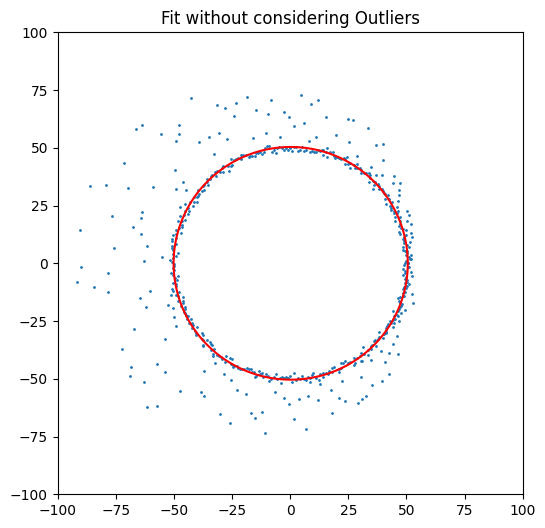

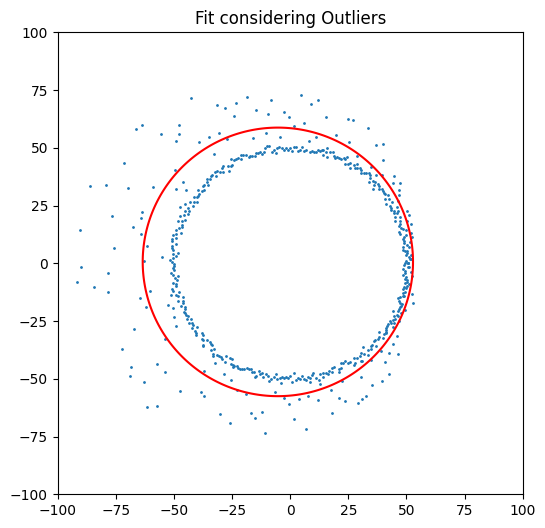

In [13]:
# define function for algebraic fitting
def algebraic_fitting(x, y):
    X = np.column_stack((x**2 + y**2, x, y, np.ones_like(x)))
    U, S, V = np.linalg.svd(X)
    a, b, c, d = V[-1]
    return a, b, c, d

# Algebraic Fit the circle
a, b, c, d = algebraic_fitting(x_filtered, y_filtered)
a1, b1, c1, d1 = algebraic_fitting(x, y)


# Plot results

visualize_fit(x, y, a, b, c, d, "Fit without considering Outliers")
visualize_fit(x, y, a1, b1, c1, d1, "Fit considering Outliers")





#### From a visual perspective, the fit appears satisfactory with the cleaned data; however, since we are taking all points into account, it’s evident that the fit is actually poor! Certainly, this can be enhanced by employing more advanced methods, such as RANSAC.

### c)

In [17]:
#Implement Ransac algorithm

def ransac_circle_fit(x, y, s=3, t=360, N=1000, threshold=0.1):
    """RANSAC algorithm to fit a circle."""
    best_inliers = []
    best_model = None

    for _ in range(N):
        # Step 1: Randomly select a minimal sample (size s)
        sample_indices = random.sample(range(len(x)), s)
        x_sample = x[sample_indices]
        y_sample = y[sample_indices]
        
        # Step 2: Estimate the model using algebraic fitting
        a, b, c, d = algebraic_fitting(x_sample, y_sample)
        
        # Step 3: Determine the consistent set (inliers)
        inliers = []
        for i in range(len(x)):
            # Calculate the algebraic error
            error = abs(a * (x[i]**2 + y[i]**2) + b * x[i] + c * y[i] + d)
            if error < threshold:
                inliers.append(i)
        
        # Step 4: If the size of the consistent set is greater than threshold t, terminate
        if len(inliers) > t:
            # If this model has more inliers, update the best model
            if len(inliers) > len(best_inliers):
                best_inliers = inliers
                best_model = (a, b, c, d)
        
    # Step 5: After N trials, select the best model
    if best_model is not None:
        # Step 6: Re-estimate the model using all inliers
        x_inliers = x[best_inliers]
        y_inliers = y[best_inliers]
        a, b, c, d = algebraic_fitting(x_inliers, y_inliers)
        
    return a, b, c, d, best_inliers



#### d)

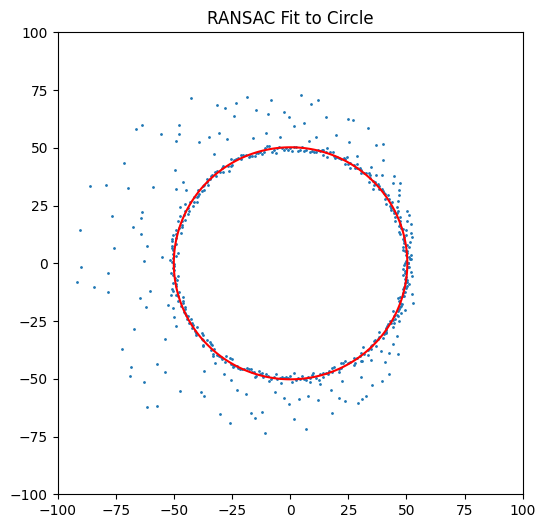

In [18]:
# apply ransac to the points
a_ransac, b_ransac, c_ransac, d_ransac, inliers = ransac_circle_fit(x, y)

# Visualize the results
visualize_fit(x, y, a_ransac, b_ransac, c_ransac, d_ransac, "RANSAC Fit to Circle")


#### It is clear that RANSAC achieves results comparable to algebraic fitting when applied to cleaned data. However, it's important to note that this algorithm performs effectively even without preprocessing, such as eliminating outliers in this scenario.